In [17]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


In [7]:
conda install opencv

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

# All requested packages already installed.




In [26]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [131]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [133]:
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haarcascade_eye.xml')

In [418]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        return roi_color
        #if len(eyes) >= 2:
          #  return roi_color

In [419]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [421]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [411]:
img_dirs

['./dataset/cropped',
 './dataset/Jim Iyke',
 './dataset/Nkem owoh',
 './dataset/Zack Orji']

In [422]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [423]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
celebrity_name=None
for img_dir in img_dirs:
    count = 1
    if os.path.basename(img_dir) !='cropped':
       celebrity_name = os.path.basename(img_dir)
    
    print(os.path.basename(img_dir))
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".jpg"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

cropped
Jim Iyke
Generating cropped images in folder:  ./dataset/cropped/Jim Iyke
Nkem owoh
Generating cropped images in folder:  ./dataset/cropped/Nkem owoh
Zack Orji
Generating cropped images in folder:  ./dataset/cropped/Zack Orji


In [424]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{None: 0, 'Jim Iyke': 1, 'Nkem owoh': 2, 'Zack Orji': 3}

In [390]:
celebrity_file_names_dict

{None: [],
 'Jim Iyke': ['./dataset/cropped/Jim Iyke/Jim Iyke1.jpg'],
 'Nkem owoh': ['./dataset/cropped/Nkem owoh/Nkem owoh1.jpg'],
 'Zack Orji': ['./dataset/cropped/Zack Orji/Zack Orji1.jpg',
  './dataset/cropped/Zack Orji/Zack Orji2.jpg',
  './dataset/cropped/Zack Orji/Zack Orji3.jpg',
  './dataset/cropped/Zack Orji/Zack Orji4.jpg']}

In [425]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        
        img = cv2.imread(training_image)
        
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        
        scalled_img_har = cv2.resize(img_har, (32, 32))
        
        
       
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        
       # plt.imshow(scalled_img_har, interpolation='nearest')
       # plt.show()
       
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [380]:
len(X[0])

4096

In [426]:
X = np.array(X).reshape(len(X),4096).astype(float)

X.shape


(15, 4096)

In [427]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [213]:
X

array([[ 19.,  18.,  24., ..., 249., 245., 242.],
       [250., 255., 254., ...,   3., 124., 252.],
       [ 11.,   7.,  12., ...,  29.,  24., 249.],
       [ 34.,  38.,  67., ..., 235., 239., 241.],
       [105., 119., 117., ..., 255., 119.,   0.]])

In [429]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)



0.75

In [430]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [431]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [432]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=2, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\FINTRAK-MIS\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\FINTRAK-MIS\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\FINTRAK-MIS\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


,model,best_score,best_params
0,svm,0.550000,"{'svc__C': 1, 'svc__kernel': 'rbf'}"
1,random_forest,0.733333,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.283333,{'logisticregression__C': 1}


In [434]:
best_estimators['svm'].score(X_test,y_test)

0.75

In [436]:
best_estimators['random_forest'].score(X_test,y_test)

0.5

In [437]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.75

In [440]:
best_clf = best_estimators['svm']

In [441]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[0, 1],
       [0, 3]], dtype=int64)

Text(69.0, 0.5, 'Truth')

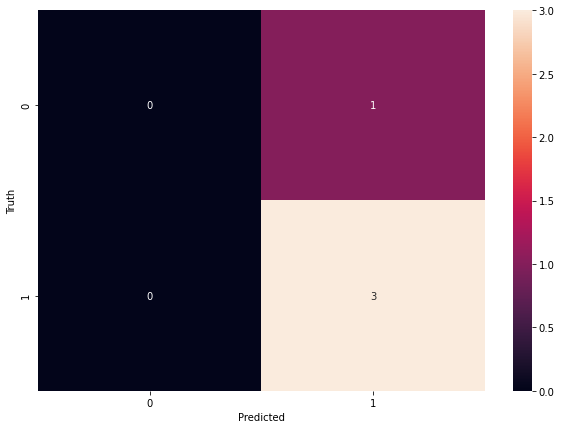

In [442]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [403]:
class_dict

{None: 0, 'Jim Iyke': 1, 'Nkem owoh': 2, 'Zack Orji': 3}

In [57]:
!pip install joblib

In [404]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'Image_model.pkl')

['Image_model.pkl']

In [405]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))